# Detectron2 OCT for SOTA comparison

First we have to COCOify the dataset so see jpg to COCO

In [1]:
#export
import detectron2

import os, sys, time, random
import numpy as np
from pathlib import Path
from pycocotools.coco import COCO
import cv2

from detectron2.data.datasets import load_coco_json
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2 import model_zoo
from detectron2.evaluation import DatasetEvaluator,DatasetEvaluators

import matplotlib.pyplot as plt
import torch

In [2]:
projectname = 'OCT'

In [ ]:
anno_file_name = 'medium_set_annotations.json' #full is annotations.josn med is 'medium_set_annotations.json'

In [ ]:
checkpoint_name = '01_pawsey'

In [ ]:
runsaves_dir = Path('/workspace/oct_ca_seg/runsaves/')

In [ ]:
data_path = Path('/workspace/oct_ca_seg/COCOdata/')
train_path = data_path/'train'
valid_path = data_path/'valid'
test_path = data_path/'test'

In [ ]:
trainCOCO = COCO(train_path/('images/'+anno_file_name))
validCOCO = COCO(valid_path/('images/'+anno_file_name))
testCOCO = COCO(valid_path/('images/'+anno_file_name))

In [ ]:
trainDetectronDataset = load_coco_json(train_path/('images/'+anno_file_name), train_path/'images', dataset_name=train_path.name)
validDetectronDataset = load_coco_json(valid_path/('images/'+anno_file_name), valid_path/'images', dataset_name=valid_path.name)
testDetectronDataset = load_coco_json(test_path/('images/'+anno_file_name), test_path/'images', dataset_name=test_path.name)

In [9]:
for d in [train_path, valid_path, test_path]:
    DatasetCatalog.register(projectname + d.name,
                            lambda d=d: load_coco_json(d/('images/'+anno_file_name), d/'images', dataset_name=d.name))  #get_dicts(d.name))#
    MetadataCatalog.get(projectname+ d.name).set(stuff_classes=["lumen"])

In [10]:
train_metadata = MetadataCatalog.get(projectname+'train')
train_metadata.stuff_classes = ['lumen']
train_metadata.thing_classes = ['lumen']
train_metadata.json_file = str(train_path/('images/'+anno_file_name))

valid_metadata = MetadataCatalog.get(projectname+'valid')
valid_metadata.stuff_classes = ['lumen']
valid_metadata.thing_classes = ['lumen']
valid_metadata.json_file = str(valid_path/('images/'+anno_file_name))

test_metadata = MetadataCatalog.get(projectname+'test')
test_metadata.stuff_classes = ['lumen']
test_metadata.thing_classes = ['lumen']
test_metadata.json_file = str(test_path/('images/'+anno_file_name))

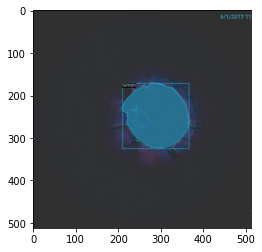

In [11]:
for d in random.sample(testDetectronDataset, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

In [12]:
cfg = get_cfg()
cfg.merge_from_file(str(runsaves_dir/(checkpoint_name+'/01_OCTPawsey_model_mask_rcnn_R_50_FPN_3x.yaml'))) #model_zoo.get_config_file("COCO-InstanceSegmentation/01_OCTPawsey_model_mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (projectname+"train",)
cfg.DATASETS.TEST = (projectname+"valid",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False
cfg.MODEL.WEIGHTS = str(runsaves_dir/(checkpoint_name+'/model_final.pth'))#use this to download model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 1  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)
cfg.OUTPUT_DIR = '/workspace/oct_ca_seg/runsaves/1_pawsey'

In [13]:
cfg.MODEL.WEIGHTS

'/workspace/oct_ca_seg/runsaves/01_pawsey/model_final.pth'

In [14]:
cfg.OUTPUT_DIR

'/workspace/oct_ca_seg/runsaves/1_Pawsey'

This saves the config in the out put directory be careful because of this youll override if retraining the model

In [28]:
#export
def save_cfg(cfg, fp):
    with open(fp, 'w') as file:
        file.write(cfg.dump())

In [15]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/03 05:37:03 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [16]:
#export
def annsToSingleBinMask(cocoset, img_id):
    anns = cocoset.imgToAnns[img_id]
    if len(anns) == 0:
        h, w = cocoset.imgs[img_id]['height'], cocoset.imgs[img_id]['width']
        return np.zeros((h,w))
    else:
        masks = cocoset.annToMask(anns[0])
        for ann in anns[1:]:
            masks = masks + cocoset.annToMask(ann) #assumption that lumen annotations never overlap
        return masks

In [17]:
#export
def lossdice(c,l, iou:bool=False, eps:float=1e-8):
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = l.shape[0]
    c = c.view(n,-1).float()
    l = l.view(n,-1)
    intersect = (c * l).sum().float()
    union = (c+l).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return (intersect / (union-intersect+eps) if union > 0 else union.new([1.]).squeeze())

In [18]:
#export
def Sens(c, l):
    #returns sens of argmaxxed predition. 
    #print(c.size(), l.size())
    n_targs=l.size()[0]
    c =(c.view(n_targs, -1) > 0).float()
    l=(l.view(n_targs, -1) > 0).float()
    inter = torch.sum(c*l, dim=(1))
    union = torch.sum(c, dim=(1)) + torch.sum(l, dim=1) - inter
    #print(inter.size(), union.size())
    return inter/union

In [19]:
#export
def Spec(c,l):
    #returns sens of argmaxxed predition. 
    n_targs=l.size()[0]
    c =(c.view(n_targs, -1) > 0).float()
    l=(l.view(n_targs, -1) > 0).float()
    c = 1-c
    l=1-l
    inter = torch.sum(c*l, dim=(1))
    union = torch.sum(c, dim=(1)) + torch.sum(l, dim=1) - inter
    return inter/union

In [20]:
#export
def Acc(c, l):
    n_targs=l.size()[0]
    c =(c.view(n_targs, -1) > 0).float()
    l=(l.view(n_targs, -1) > 0).float()
    c = torch.sum(torch.eq(c,l).float(),dim=1)
    return (c/l.size()[-1]).mean()

In [21]:
#export
class OCT_Evaluator(DatasetEvaluator):
    def __init__(self, validset):
        self.validset = validset
        
    def reset(self):
        self.dices = {} 
        self.sens = {} 
        self.specs = {} 
        self.accs = {} 
        self.scores = {}
        
    def process(self, inputs, outputs):
        for input, output in zip(inputs, outputs):
            id = input['image_id']
            pred_masks = output['instances'].pred_masks.clone().detach().int()
            pred_masks = pred_masks.sum(dim=0).unsqueeze(0)
            pred_masks = (pred_masks>0).float()
            labels = torch.tensor(annsToSingleBinMask(self.validset, id)).cuda().unsqueeze(0)
            #labels = torch.tensor(self.validset.annToMask(self.validset.anns[id])).cuda().unsqueeze(0)
            #print(pred_masks.size(), labels.size())
            self.dices[id] = lossdice(pred_masks, labels).cpu().item()
            #print(Sens(pred_masks, labels).cpu().size())
            self.sens[id] = Sens(pred_masks, labels).cpu().item()
            self.specs[id] = Spec(pred_masks, labels).cpu().item()
            self.accs[id] = Acc(pred_masks, labels).cpu().item()
            
            if len(output['instances'].scores) == 0: scores = None
            elif len(output['instances'].scores) > 0: scores = list(output['instances'].scores.cpu().numpy()) 
    def evaluate(self):
        # save self.count somewhere, or print it, or return it.
        return {"dices": self.dices,
                "accs": self.accs,
                "sens": self.sens,
                "specs": self.specs,
                "scores": self.scores}

In [ ]:
%%time
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set the testing threshold for this model
predictor = DefaultPredictor(cfg)


coco_ev = COCOEvaluator(projectname+"valid", cfg, False, output_dir=cfg.OUTPUT_DIR)
OCT_ev = OCT_Evaluator(validCOCO)

evaluators = DatasetEvaluators([coco_ev, OCT_ev])
val_loader = build_detection_test_loader(cfg, projectname+"valid")
results = inference_on_dataset(predictor.model, val_loader, evaluators)

In [67]:
!chmod +x ./notebook2script.py 

In [68]:
! ./notebook2script.py ./detectron.ipynb

Traceback (most recent call last):
  File "./notebook2script.py", line 3, in <module>
    import json,fire,re
ModuleNotFoundError: No module named 'fire'
